# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import json

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications import SimpleCNNLarge, ResNet50, DenseNet121
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet
from vbranch.utils import *

Using TensorFlow backend.


In [3]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'densenet'
DATASET = 'market'
NUM_BRANCHES = 1
SHARED_FRAC = 0.

EPOCHS = 10
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128
# IMG_DIM = (256, 128, 3)
IMG_DIM = (128, 64, 3)

In [4]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}-dim{}_{:d}'.format(DATASET, ARCHITECTURE, IMG_DIM[0], MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}-dim{}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, IMG_DIM[0], MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/market-densenet-dim128_1


## Load Data

In [5]:
P, K = 18, 4
train_generator = TripletDataGenerator(DATASET, 'train', 
                                       P=P, K=K,
                                       preprocess=ARCHITECTURE, 
                                       img_dim=IMG_DIM)

TripletDataGenerator CONFIG
Dataset:	 market
Split:		 train
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Flatten:	 True
Labels:		 False


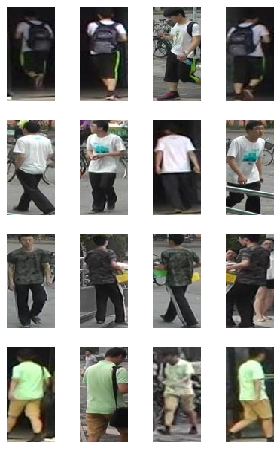

In [6]:
batch = train_generator.sample(4, 4, flatten=False, 
                             preprocess=False, 
                             img_dim=IMG_DIM)
plt.figure(figsize=(5, 8))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 4*i+j+1)
        plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
        plt.axis('off')
plt.show()

In [7]:
batch.min(), batch.max()

(0, 255)

## Build Model

In [8]:
inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, 
                                                                  (None,)+IMG_DIM, 
                                                                  n=NUM_BRANCHES)
print(inputs)

W0720 12:40:46.772602 139793727706880 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:182: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 12:40:46.794416 139793727706880 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the depre

Tensor("input:0", shape=(?, 128, 64, 3), dtype=float32)


In [9]:
lr = tf.placeholder('float32', name='lr')
beta1 = tf.placeholder('float32', shape=[], name='beta1')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)
beta1_sched = beta1_scheduler(T_0)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, 
                               shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'resnet':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
    elif ARCHITECTURE == 'densenet':
        model, assign_ops = DenseNet121(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1)

    # Compile model
    model.compile(optimizer, triplet(P,K, margin='soft'), 
                  train_init_op, test_init_op, 
                  callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES, 
                                              preprocess=ARCHITECTURE, 
                                              buffer=1000, img_dim=IMG_DIM)},
                  schedulers={'lr:0': lr_scheduler, 'beta1:0':beta1_sched},  
                  assign_ops=assign_ops)

W0720 12:40:46.832146 139793727706880 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:169: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0720 12:40:46.832756 139793727706880 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:172: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0720 12:40:46.833176 139793727706880 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:172: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0720 12:40:46.833948 139793727706880 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:175: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 12:40:46.836748 139793727706880 deprecation.py:506] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: 

Loading weights for DenseNet121...


W0720 12:40:54.554215 139793727706880 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

i    Layer name                      Output shape      Parameters          Num param  Inbound               
------------------------------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                                        
------------------------------------------------------------------------------------------------------------
0    zero_pad (ZeroPadding2D)        [None,134,70,3]                       0          input:0               
------------------------------------------------------------------------------------------------------------
1    conv1/conv (Conv2D)             [None,64,32,64]   [7,7,3,64]          9408       zero_pad              
------------------------------------------------------------------------------------------------------------
2    conv1/bn (BatchNormalization)   [None,64,32,64]   [64] [64]           128        conv1/conv            
-------------------

In [11]:
print(model.output)

Tensor("model/output/output:0", shape=(?, 128), dtype=float32)


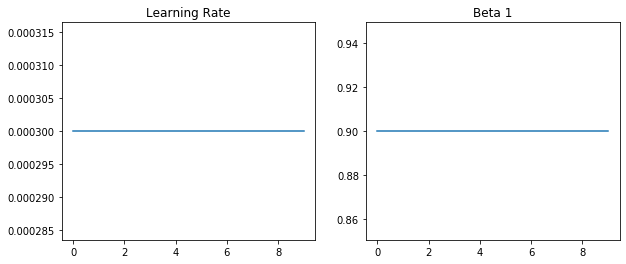

In [12]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
beta1_steps = [beta1_sched(e + 1) for e in range(EPOCHS)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lr_steps)
plt.title('Learning Rate')

plt.subplot(1,2,2)
plt.plot(beta1_steps)
plt.title('Beta 1')

plt.show()

In [13]:
# lr_steps[149]

In [14]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, log_path=model_path if SAVE else None, 
                    call_step=10, verbose=1)

Epoch 1/10
100/100 [==============================] - 49s 492ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 1396.3185
Epoch 2/10
100/100 [==============================] - 22s 221ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 782.2420
Epoch 3/10
100/100 [==============================] - 22s 223ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 471.9000
Epoch 4/10
100/100 [==============================] - 22s 223ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 327.6816
Epoch 5/10
100/100 [==============================] - 22s 223ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 215.7979
Epoch 6/10
100/100 [==============================] - 22s 222ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 172.7671
Epoch 7/10
100/100 [==============================] - 22s 223ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 131.2720
Epoch 8/10
100/100 [==============================] - 22s 223ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 123.1338
Epoch 9/10
100/

W0720 12:46:25.958194 139793727706880 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/engine/training.py:264: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



## Evaluation

In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=False)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 95s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 21s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 18.550950050354004
{'mAP': 0.6934945495051927, 'rank1': 0.8423397, 'rank5': 0.9403207}


In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=True)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 97s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 22s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 33.23809599876404
{'mAP': 0.6466024319270626, 'rank1': 0.8111639, 'rank5': 0.9275534}
